# **Install libraries**

In [ ]:
!pip install torch_geometric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 22.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch_geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910459 sha256=0e9f38ffd919cd153db9895224362c00327003f69405092ba2f0a5e4179ee091
  Stored in directory: /root/.cache/pip/wheels/ac/dc/30/e2874821ff308ee67dcd7a66dbde912411e19e35a1addda028
Successfully built torch_geometric


# **Parser**

Please change the directory to the proper one that you've saved the dataset in.

In [4]:
from google.colab import drive
drive.mount('/content/gdrive/')
directory = '/content/gdrive/MyDrive/University/HLS/GNN/'
file_list = ['syrk.c.021t.ssa.c', '2mm.c.021t.ssa.c', 'jacobi_2d.c.021t.ssa.c', 'adi.c.021t.ssa.c', 'fdtd_2d.c.021t.ssa.c',
             'Tsyrk.c.021t.ssa.c', 'T2mm.c.021t.ssa.c']

ModuleNotFoundError: No module named 'google.colab'

In [1]:
#SRA change
directory = 'data/' 
file_list = ['syrk.c.021t.ssa.c', '2mm.c.021t.ssa.c', 'jacobi_2d.c.021t.ssa.c', 'adi.c.021t.ssa.c', 'fdtd_2d.c.021t.ssa.c',
             'Tsyrk.c.021t.ssa.c', 'T2mm.c.021t.ssa.c']

In [2]:
def check_finish_teavers(visted_vertex, BB_adjacent_mat):
    for vertex in visted_vertex:
        if visted_vertex[vertex] < len(BB_adjacent_mat[vertex]):
            return 1
    return 0


def adj_mat_fun(filename):
  #The file name should be dumped using -fdump-tree-ssa-gimple. It's the 021 tree.
  lines    = []

  with open(filename, "r") as file:
      for line in file:
          lines.append(line.strip())

  #################################################################################
  #Create the list of using variables.

  function_name    = 0  #Here I just enumerate
  initial_part     = 0
  var_dict_temp    = {} #It's local for any function and has the temperory vars
  var_dict_static  = {} #It's local for any function and has the args and defined vars
  var_all          = {} #Key's are corresponded to the funcation name and values are the var_dict_temp of each function
  fun_def          = 0  #check for __GIMPLE to see if we are at the beginning of a function

  for line in lines:
      words = line.split()  
      
      if fun_def: #since we know the immidiate line after the __GIMPLE is the argument lines of the function
          fun_def = 0
          args = line.split(sep=',') #first split it based on ','
          for arg in args:
              arg_list = arg.split()
              if '(' not in arg: #check if it is the first arguman and has the function name and other stuff in it
                  if ')' not in arg: #check if it is the last arguman and has the last ')'
                      var_dict_static[arg_list[-1]] = arg[1:-(len(arg_list[-1])+1)]
                  else:
                      var_dict_static[arg_list[-1][0:-1]] = arg[1:-(len(arg_list[-1])+1)]
              else:
                  par_ind = arg.find('(')
                  if ')' not in arg:
                      var_dict_static[arg_list[-1]] = arg[par_ind+1:-(len(arg_list[-1])+1)]
                  else:
                      if '(' not in arg_list[-1]:
                          var_dict_static[arg_list[-1][0:-1]] = arg[par_ind+1:-(len(arg_list[-1])+1)]

      for word in words:
          if '__GIMPLE' in word: #check for the __GIMPLE that is a distinctive annotation for the beginning of the function
              fun_def                 = 1
          
          if '{' in word: #check to see if we are in the function scope.
              initial_part            = 1 #since in the SSA all the initializations are at the beginning
          if '}' in word: #check to see if we are out of the function scope.
              var_all_local           = {} #to have temp and static vars in dict
              var_all_local['static'] = var_dict_static
              var_all_local['temp']   = var_dict_temp
              var_all[function_name]  = var_all_local #updating var_all for values in the parsed function
              var_dict_temp           = {} #clear the local var_dict_temp
              var_dict_static         = {} #clear the local var_dict_static
              function_name          += 1 #increase the index of function
          if '__BB' in word:
              initial_part            = 0 #check the end of initialization
      
      if initial_part and len(words)>1:
          if words[-1][0] == '_': #having '_' at the beginning indicates it's temperoray and made by the compiler
              var_dict_temp[words[-1][0:-1]]   = line[0:-(len(words[-1])+1)]
          else:
              var_dict_static[words[-1][0:-1]] = line[0:-(len(words[-1])+1)]
          
  #################################################################################
  #Create the adjacent matrix for BBs
  fun_def                  = 0  #check for __GIMPLE to see if we are at the beginning of a function
  function_scope           = 0  #to check if we are inside a scope
  function_name            = 0  #Here I just enumerate
  BB_name                  = 0  #to have the name of current BB. It's only valid if BB_scope=1
  BB_ind                   = -1 #to store a numeric value for BBs.
  BB_scope                 = 0  #to check if we are inside a scope
  BB_first_line            = 0  #to store the BBs name and info
  BB_local_dict            = {} #it has the 0-indexed vertex as key and BBs name in val for each function
  BB_global_dict           = {} #it has the 0-indexed vertex as key and BBs name in val for all functoins
  BB_rev_local_dict        = {} #it has the 0-indexed vertex as val and BBs name in key for each function
  BB_rev_global_dict       = {} #it has the 0-indexed vertex as val and BBs name in key for all functoins
  BB_adjacent_mat          = [] #it's for all the BBs inside a function
  BB_local_adj             = [] #it's local to each BB in a function
  BB_adjacent_mat_global   = {} #it's for all of the funcitons
  BB_livness               = [] #it's for all the BBs inside a function
  BB_livness_local         = set() #it's local to each BB in a function
  BB_livness_gloabal       = {} #it's for all of the funcitons
  BB_livness_start         = {} #it's for all the BBs inside a function
  BB_livness_gloabal_start = {} #it's for all of the funcitons
  BB_all_val               = [] #have all the variable use in a function
  BB_all_val_global        = {} #have entire variables
  for line in lines:
      words = line.split()

      if fun_def: #since we know the immidiate line after the __GIMPLE is the argument lines of the function
          fun_def = 0

      if '__GIMPLE' in line: #check for the __GIMPLE that is a distinctive annotation for the beginning of the function
          fun_def                                 = 1
          
      if '{' in line: #check to see if we are in the function scope.
          function_scope                          = 1 #check if we are inside of the function scope 
      if '}' in line: #check to see if we are out of the function scope.
          function_scope                          = 0   
          BB_global_dict[function_name]           = BB_local_dict
          BB_local_dict                           = {}
          BB_rev_global_dict[function_name]       = BB_rev_local_dict
          BB_rev_local_dict                       = {}
          BB_adjacent_mat.append(BB_local_adj)
          BB_adjacent_mat_global[function_name]   = BB_adjacent_mat
          BB_local_adj                            = []
          BB_adjacent_mat                         = []
          BB_livness.append(BB_livness_local)
          BB_livness_gloabal[function_name]       = BB_livness
          BB_livness_gloabal_start[function_name] = BB_livness_start
          BB_livness_local                        = set()
          BB_livness                              = []
          BB_livness_start                        = {}
          BB_ind                                  = -1
          function_name                          += 1 #increase the index of function

      if line[0:4] == '__BB':
          BB_scope                        = 1 #check that we are inside a BB
          BB_first_line                   = 1
      
      if BB_first_line: #store BBs data
          if BB_ind>=0: #not for the first one
              BB_adjacent_mat.append(BB_local_adj)
              BB_livness.append(BB_livness_local)
          BB_local_adj                    = [] 
          BB_livness_local                = set()
          BB_livness_local_start          = set()
          BB_first_line                   = 0 #reset the first line flag for BBs
          start                           = line.find('(')+1
          if line.find(',') > 0: #check if there is other info
              end                         = line.find(',')
          else:  
              end                         = line.find(')') 
          BB_name                         = line[start: end]
          BB_ind                         += 1
          BB_local_dict[BB_ind]           = int(BB_name) #update the local dict for BBs' name
          BB_rev_local_dict[int(BB_name)] = BB_ind
      
      if BB_scope:
          if ' =' in line: #Check if there is an assignment. This can be consider as the start of the livenss analysis since the tree is in SSA form
              if '__MEM' not in words[0]:
                  BB_livness_local.add(words[0])
                  BB_livness_start[words[0]] = BB_ind
              
              for word in words:
                  var  = ''
                  vars = set()
                  if '_' in word and '__' not in word:
                      for char in word:
                          asci = ord(char)
                          if (asci<=90 and asci >=65) or (asci<=57 and asci>=48) or (asci<=122 and asci>=97) or char =='_':
                              var += char                
                          else:
                              if len(var)>0:
                                  vars.add(var)
                                  var = ''
                      vars.add(var)
                      for var in vars:
                          if '_' in var:
                              BB_livness_local.add(var)

          if 'goto' in line:
              start = line.find('B')+2
              BB_local_adj.append(int(line[start:-1]))
          if 'return' in line:
              BB_local_adj.append(-1)

  #################################################################################
  #Traversing the tree to check the liveness

  live_global    = BB_livness_gloabal #To store liveness for each BBs of all function 
  live_local     = set() #To store liveness for each BBs of each function 
  live           = [] #to store liveness for each function
  visited        = [] #To store visited edge of all functions
  visited_times  = [] #To store number of visited edge of all functions
  function_name  = -1

  for BB_adjacent_mat_key in BB_adjacent_mat_global:
      BB_adjacent_mat = BB_adjacent_mat_global[BB_adjacent_mat_key]
      function_name += 1
      visited_times  = []
      for vertex in BB_adjacent_mat: #set all vertex zero visited
          visited_times.append(0)    
      while check_finish_teavers(visited_times, BB_adjacent_mat): #Continue until all paths have been visited
          next = 2
          visited = []

          while next!=-1:#Continue until the last BB
              visited.append(next)
              BB_ind   = BB_rev_global_dict[function_name][next]
              len_next = len(BB_adjacent_mat[BB_ind])
              if visited_times[BB_ind] < len_next:
                  next = BB_adjacent_mat[BB_ind][visited_times[BB_ind]]
                  visited_times[BB_ind] += 1
              else:
                  next = BB_adjacent_mat[BB_ind][visited_times[BB_ind]-1]

          for var in BB_livness_gloabal_start[function_name]:#Update the liveness of the BB in the path
              BB_ind = BB_livness_gloabal_start[function_name][var]
              BB     = BB_global_dict[function_name][BB_ind]
              start  = visited.index(BB)
              last   = start
              for i in range(start+1,len(visited)):
                  BB_ind_visited = BB_rev_global_dict[function_name][visited[i]]
                  if var in BB_livness_gloabal[function_name][BB_ind_visited]:
                      last = i
              for i in range(start+1, last+1):
                  BB_ind_visited = BB_rev_global_dict[function_name][visited[i]]
                  live_global[function_name][BB_ind_visited].add(var)


  ##################################################################################            
  

  BB_ind = 0
  adj_list = []
  for BB_local_adj in BB_adjacent_mat_global[0]:
      for adj in BB_local_adj:
          if adj > 0:
              adj_list.append([BB_global_dict[0][BB_ind]-2, adj-2])
      BB_ind += 1

  BB_ind = 0
  live_list = []
  for BB_livness in BB_livness_gloabal[0]:
      live_list.append([len(BB_livness)/81])
      BB_ind += 1
  BB_ind = 0

  for BB_livness in live_global[0]:
      live_list[BB_ind].append(len(BB_livness)/88)
      BB_ind += 1
  
  return [live_list, adj_list]





The bellow part is not complete yet and it's not connected to the model.



In [ ]:
'''
# Import library
#import numpy as np
import json
import os

#Functions

#Check if a word (seprated by space) is a variable
def check_var(var, word):
    asciis = [x for x in range(60,91)]
    asciis.extend([x for x in range(97,123)])
    asciis.extend([x for x in range(48,58)])
    asciis.append(95)
    if var in word:
        if (' ' + var + '[' in word) or (' ' + var + '(' in word) or (' ' + var + ' ' in word):
            return True
        for x in asciis:
            if var + chr(x) in word:
                return False
        for x in asciis:
            if chr(x) + var in word:
                return False
        return True


# Reading the AST file
lines = []
try:
    f = open(AST_filename, 'r')
    for line in f:
        lines.append(line)
    f.close()
except:
    print('You have not dumped the corresponded AST and the program cannot do it either')


# Find nodes that have jumps/branches
current_bb     = 0
branch_bb      = 0
main_scope     = 0
last_bb        = 0
branching_node = []
loops          = []
loops_initials = []

param_nums     = 0

args = dict()

#All possible variables to be declared in the scope
cpp_var = ['char', 'char16_t', 'char32_t', 'wchar_t',
           'signed char', 'signed short int', 'short int', 'signed short', 'short', 'signed int', 'int', 'signed long int', 'signed long', 'long int', 'long', 'signed long long int', 'signed long long', 'long long int', 'long long',
           'unsigned char', 'unsigned short int', 'unsigned short', 'unsigned int', 'unsigned', 'unsigned long int', 'unsigned long', 'unsigned long long int', 'unsigned long long',
           'float', 'double', 'long double',
           'bool',
           'void',
           'decltype(nullptr)',
           'size_t']

#Asking for the name of specific function to make the json file for
print('please type the function name:')
function_name = input()

#Going through each line of the AST to extract the features
for line in lines:

    #make a list of words splitted by space out of each line
    line_words_list = line.split()

    #checking if the requried function has started  
    if function_name in line_words_list and ';;' not in line_words_list:
        main_scope    = 1
        inside_args   = 0
        val_flag      = 0
        previous_word = ''

        #Find the args of the function
        for word in line_words_list:
            if not inside_args and '(' in word:
                inside_args   = 1
                previous_word = word[1:]
                val_flag      = 1

            elif inside_args and val_flag:
                if ')' in word:
                    inside_args         = 0
                    args[word[0:len(word)-1]] = previous_word
                    val_flag            = 0
                elif '*' in word:
                    previous_word      += '*'
                else:
                    args[word[0:len(word)-1]] = previous_word
                    val_flag            = 0
            
            elif inside_args and not val_flag:
                previous_word = word
                val_flag      = 1

    #Checking for the end of the function       
    if '{' in line_words_list:
        param_nums += 1
    if '}' in line_words_list:
        param_nums -= 1
        if param_nums == 0:
            main_scope = 0

    #Finding the requried features inside the main scope of the function
    if main_scope:
        if 'goto' in line_words_list:
            flag_bb_found = 0
            for word in line_words_list:
                if word == '<bb':
                    flag_bb_found = 1
                elif flag_bb_found:
                    branch_bb = int(word.split(sep='>')[0])
                    flag_bb_found = 0
            branching_node.append([current_bb, branch_bb])

            if(current_bb > branch_bb):
                loops.append([x for x in range(branch_bb, current_bb+1)])
                loops_initials.append(current_bb)

        else:
            flag_bb_found = 0
            for word in line_words_list:
                if word == '<bb':
                    flag_bb_found = 1
                elif flag_bb_found:
                    current_bb = int(word.split(sep='>')[0])
                    flag_bb_found = 0
                    if current_bb > last_bb:
                        last_bb = current_bb


# Define type
bb_edge_type = dict()
for i in range(2,last_bb+1):
    occurence_num = 0
    for j in branching_node:
        if j[0] == i:
            occurence_num += 1
    if i in loops_initials:
        bb_edge_type[i] = 'Start of loop'
    elif occurence_num >= 1:
        bb_edge_type[i] = 'Multi-branch'
   # elif occurence_num == 1:
   #     bb_edge_type[i] = 'End of loop'
    else:
        bb_edge_type[i] = 'Simple'

#Printing the extracting features
print("BBs:")
print(bb_edge_type)

print("Loops:")
print(loops)

print('args:')
print(args)
'''

You have not dumped the corresponded AST and the program cannot do it either
please type the function name:
dsa
BBs:
{}
Loops:
[]
args:
{}


In [3]:
graphs = []
for f in file_list:
  filename = directory + f
  g = adj_mat_fun(filename)
  graphs.append(g)

In [4]:
#SRA
len(graphs)
graphs[0]

[[[0.012345679012345678, 0.011363636363636364],
  [0.037037037037037035, 0.03409090909090909],
  [0.24691358024691357, 0.22727272727272727],
  [0.06172839506172839, 0.056818181818181816],
  [0.037037037037037035, 0.03409090909090909],
  [0.06172839506172839, 0.056818181818181816],
  [0.4567901234567901, 0.42045454545454547],
  [0.08641975308641975, 0.07954545454545454],
  [0.06172839506172839, 0.056818181818181816],
  [0.06172839506172839, 0.056818181818181816],
  [0.037037037037037035, 0.03409090909090909],
  [0.037037037037037035, 0.03409090909090909],
  [0.0, 0.0]],
 [[0, 11],
  [1, 3],
  [2, 3],
  [3, 2],
  [3, 4],
  [4, 9],
  [5, 7],
  [6, 7],
  [7, 6],
  [7, 8],
  [8, 9],
  [9, 5],
  [9, 10],
  [10, 11],
  [11, 1],
  [11, 12]]]

# **Building Data**

In [5]:
import torch
from torch_geometric.data import Data

def graph_to_data(G, label=[0, 0, 0, 0, 1]):
    edge_index = torch.tensor(list(G[1])).t().contiguous()
    x = torch.tensor(G[0])  
    y = torch.tensor([label])  
    train_mask = torch.tensor([True])  
    
    return Data(x=x, edge_index=edge_index, y=y, train_mask=train_mask)

data = [graph_to_data(graphs[0], [1, 0, 0, 0, 0]), 
        graph_to_data(graphs[1], [0, 1, 0, 0, 0]),
        graph_to_data(graphs[2], [0, 0, 1, 0, 0]),
        graph_to_data(graphs[3], [0, 0, 0, 1, 0]),
        graph_to_data(graphs[4], [0, 0, 0, 0, 1]),
        graph_to_data(graphs[5], [1, 0, 0, 0, 0]),
        graph_to_data(graphs[6], [0, 1, 0, 0, 0])]

train_data = data[:5]
test_data  = data[5:]

# **GNN**

In [6]:
#SRA
print(f'features: {data[0].x}')
print(f'\nlabels: {data[0].y}')
print(f'\nedge index" {data[0].edge_index}')

features: tensor([[0.0123, 0.0114],
        [0.0370, 0.0341],
        [0.2469, 0.2273],
        [0.0617, 0.0568],
        [0.0370, 0.0341],
        [0.0617, 0.0568],
        [0.4568, 0.4205],
        [0.0864, 0.0795],
        [0.0617, 0.0568],
        [0.0617, 0.0568],
        [0.0370, 0.0341],
        [0.0370, 0.0341],
        [0.0000, 0.0000]])

labels: tensor([[1, 0, 0, 0, 0]])

edge index" tensor([[ 0,  1,  2,  3,  3,  4,  5,  6,  7,  7,  8,  9,  9, 10, 11, 11],
        [11,  3,  3,  2,  4,  9,  7,  7,  6,  8,  9,  5, 10, 11,  1, 12]])


In [7]:
import torch.nn as nn
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

'''
SRA comment:
Assuming that the labels are mutually exclusive (i.e. an input can't have more than one "1" in the label array),
we want the model's output to be a set of K probabilities (K = #distinct number of unique labels) that add to 1.

Softmax(x) = exp(x_i) / Sum_j(exp(x_j))

converts an array of numbers x, to an array of probabilities. The exp is to make numbers non-negative and the division
by the sum is to normalize the sum of probs to 1.
'''

# Define the GNN architecture
class GNNModel(nn.Module):
    def __init__(self):
        super(GNNModel, self).__init__()
        self.conv1 = GCNConv(in_channels=2, out_channels=16)
        self.conv2 = GCNConv(in_channels=16, out_channels=32)
        self.fc = nn.Linear(32, 5)  
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax()
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu() #SRA: adding another relu before fc layer (alt conv and relu)
        x = self.fc(x)
        #x = F.dropout(x, p=0.5, training=self.training)
        
        #x = self.sigmoid(x) #SRA: changing to softmax - next line
        #x = self.softmax(x) #SRA: changing to softmax
        #see comment below on "logits" and why an output activation is not needed
        
        x = torch.mean(x, dim=0, keepdim=True) #SRA comment: mean over embeddings for full graph
        
        return x

# **Training**

In [8]:
import torch.optim as optim
from torch_geometric.data import Data, DataLoader

model = GNNModel()

# Define the loss function and optimizer

#criterion = nn.BCEWithLogitsLoss() #SRA: commenting BCE and replacing with CrossEntropyLoss below
criterion = nn.CrossEntropyLoss() #SRA: please see comment below

'''
Change 1: BCE vs CrossEntropy
BCEWithLogitsLoss is used when one is doing binary classification i.e. the output is 0/1 (two classes)

More precisely, the labels are assumed to be 0/1 (or [1,0] and [0,1]) and the 
predictions are two probabilities [p1, p2] with p1 + p2 == 1

If the label is [1,0]: BCE loss = -log(p1)
If the label is [0,1]: BCE loss = -log(p2)

If the appropriate pj == 1, then the model predicted the output with prob 1 and the loss==0
If the appropriate pj == 0, then the model predicted the output with prob 0 and the loss==\infty

CrossEntropyLoss is a generalization of BCE loss to more than two output categories. The loss is still
-log(p_k) where class k is the correct label.

CrossEntropyLoss doc: https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html

Change 2: Output activation vs no output activation
For both BCEWithLogits and CrossEntropyLoss, the predicted is expected to be the "logits" i.e.
the network's output before applying softmax (the raw x_j passes to the softmax)

This is done for numerical reasons so we are not exponentiating and then taking logs of the inputs.

Practically, this means we need to remove the softmax from the forward() function in the GNN

'''

#optimizer = optim.Adam(model.parameters(), lr=0.01) #SRA: changing to AdamW - not crucial
optimizer = optim.Adam(model.parameters(), lr=1e-2) #SRA: making lr much smaller for now

# Define the training loop
#SRA: todo: we'll add batching here later
def train(model, data, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    output = model(data)
    loss = criterion(output, data.y.float())  # Apply sigmoid activation and compare with target labels
    loss.backward()
    optimizer.step()
    return loss.item()

# Define the evaluation function
def evaluate(model, data):
    model.eval()
    with torch.no_grad():
        output = model(data)
        predicted_labels = output > 0.5  # Threshold the output for binary predictions
        accuracy = (predicted_labels == data.y).all(dim=1).float().mean()
    return accuracy.item()

# Training loop
num_epochs = 1000
print_freq = 50 #adding printing every print_freq epochs
for epoch in range(num_epochs):
    train_loss = 0.0
    for data in train_data:
        train_loss += train(model, data, optimizer, criterion)
    train_loss /= len(train_data)
    test_scores = []
    for data in test_data:
        test_scores.append(evaluate(model, data))
    test_avg_score = sum(test_scores) / len(test_scores)
    if epoch % print_freq == 0: #SRA
        print(f"Epoch: {epoch+1}, Train Loss: {train_loss}, Test Avg. Accuracy: {test_avg_score}")

Epoch: 1, Train Loss: 1.6392825365066528, Test Avg. Accuracy: 0.0
Epoch: 51, Train Loss: 0.9848950117826462, Test Avg. Accuracy: 0.0
Epoch: 101, Train Loss: 0.6098291148431599, Test Avg. Accuracy: 0.5
Epoch: 151, Train Loss: 0.3747448703739792, Test Avg. Accuracy: 0.0
Epoch: 201, Train Loss: 0.21420740137109534, Test Avg. Accuracy: 0.0
Epoch: 251, Train Loss: 0.11709804106503725, Test Avg. Accuracy: 0.0
Epoch: 301, Train Loss: 0.06652252778003458, Test Avg. Accuracy: 0.0
Epoch: 351, Train Loss: 0.03983325359586161, Test Avg. Accuracy: 0.0
Epoch: 401, Train Loss: 0.025404343764239456, Test Avg. Accuracy: 0.0
Epoch: 451, Train Loss: 0.01716075670265127, Test Avg. Accuracy: 0.0
Epoch: 501, Train Loss: 0.01206410508020781, Test Avg. Accuracy: 0.0
Epoch: 551, Train Loss: 0.008803506836193265, Test Avg. Accuracy: 0.0
Epoch: 601, Train Loss: 0.006574487510806648, Test Avg. Accuracy: 0.0
Epoch: 651, Train Loss: 0.005015153648491833, Test Avg. Accuracy: 0.0
Epoch: 701, Train Loss: 0.00389979622

## Embeddings example

In [40]:
import numpy as np

In [51]:
#create a uniq integer id for every uniq node feature vector
counter = -1
node_to_idx = {}
idx_to_node = {}

for g in train_data + test_data:
    for feat in g.x:
        feat = tuple(feat.numpy())
        
        if feat not in node_to_idx:
            counter += 1        
        
            node_to_idx[feat] = counter
            idx_to_node[counter] = feat

In [52]:
#nodes in train and test sets respectively
uniq_train_nodes, uniq_train_counts = \
np.unique([node_to_idx[tuple(feat.numpy())] for g in train_data for feat in g.x], return_counts=True)

uniq_test_nodes, uniq_test_counts = \
np.unique([node_to_idx[tuple(feat.numpy())] for g in test_data for feat in g.x], return_counts=True)

In [53]:
set(uniq_test_nodes).difference(uniq_train_nodes) #no nodes in test that haven't occurred in train

set()

In [47]:
idx_to_node

{0: (0.012345679, 0.011363637),
 1: (0.037037037, 0.03409091),
 2: (0.24691358, 0.22727273),
 3: (0.061728396, 0.056818184),
 4: (0.45679012, 0.42045453),
 5: (0.086419754, 0.07954545),
 6: (0.0, 0.0),
 7: (0.14814815, 0.13636364),
 8: (0.4814815, 0.4431818),
 9: (0.074074075, 0.06818182),
 10: (0.72839504, 0.67045456),
 11: (0.13580246, 0.125),
 12: (0.09876543, 0.09090909),
 13: (0.30864197, 0.2840909),
 14: (0.11111111, 0.10227273),
 15: (0.38271606, 0.35227272),
 16: (1.0864197, 1.0),
 17: (0.20987654, 0.19318181),
 18: (0.54320985, 0.5),
 19: (0.16049382, 0.14772727),
 20: (0.17283951, 0.1590909),
 21: (0.39506173, 0.36363637),
 22: (1.074074, 0.9886364),
 23: (0.19753087, 0.18181819),
 24: (0.18518518, 0.17045455),
 25: (0.50617284, 0.4659091),
 26: (0.7160494, 0.65909094)}

In [56]:
len(idx_to_node)
emb = nn.Embedding(len(idx_to_node), 32)

In [63]:
emb(torch.tensor([node_to_idx[tuple(k.numpy())] for k in train_data[0].x]))

tensor([[-2.8253e-02,  1.3466e+00, -3.1387e-01,  1.4164e-01,  2.9588e-01,
          7.4842e-01, -1.3400e+00,  8.7208e-01, -6.8283e-01,  6.0447e-01,
          6.3925e-01,  9.8095e-01, -1.0009e+00, -1.5836e+00, -5.4064e-01,
          6.7377e-01, -9.6340e-01, -3.7982e-01,  4.3706e-01,  1.4391e+00,
         -8.8762e-01, -1.7207e+00, -2.7347e-02, -7.8145e-01, -1.0155e-01,
          4.6511e-02, -1.7704e+00,  3.0134e-01, -2.7252e+00,  5.7772e-01,
          3.5641e-01,  1.3954e-01],
        [ 3.8283e-02,  1.2365e-03,  6.0099e-02,  1.5830e+00, -7.0656e-01,
         -5.5937e-01, -2.3959e+00, -2.2393e-01, -1.2264e+00, -1.0645e+00,
          4.5650e-01, -6.2831e-02,  6.5994e-01,  1.2557e+00, -1.1108e+00,
         -3.4818e-01,  2.5510e-01, -1.6056e+00, -4.4696e-01,  4.0074e-01,
          1.1722e+00,  4.4735e-01,  7.4569e-01,  2.8878e-01,  8.6507e-01,
          3.9693e-01, -5.2737e-02, -5.5811e-01, -1.6311e+00, -2.9935e-01,
         -4.2286e-02, -2.0938e-01],
        [ 7.1668e-01, -1.4286e+00,  1.23

In [91]:
import torch.nn as nn
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

# Define the GNN architecture
'''we are adding embeddings here:

The idea is to use the uniq integer id for each node
to look up new features in an embeddings hash table.

While all the nodes in our test set also occur in
our train set, this doesn't have to be the case. We'll
use an unknown node that is a bucket for all nodes not
seen in the train set.

'''
class GNNModel(nn.Module):
    def __init__(self, idx_to_node, 
                 node_to_idx,
                 emb_dim):
        
        super(GNNModel, self).__init__()
        
        self.idx_to_node = idx_to_node
        self.node_to_idx = node_to_idx
        
        self.emb = nn.Embedding(len(idx_to_node), emb_dim) #change
        
        self.conv1 = GCNConv(in_channels=emb_dim, out_channels=16) #change: in_channels= emb_dim
        self.conv2 = GCNConv(in_channels=16, out_channels=32)
        
        self.fc = nn.Linear(32, 5)  
        
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax()
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        #map node features -> id -> embedding
        #eventually input data might not have node features and would consist of just ids
        x = self.emb(torch.tensor([self.node_to_idx[tuple(k.numpy())] for k in x]))
        
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu() #SRA: adding another relu before fc layer (alt conv and relu)
        x = self.fc(x)
        #x = F.dropout(x, p=0.5, training=self.training)
        
        #x = self.sigmoid(x) #SRA: changing to softmax - next line
        #x = self.softmax(x) #SRA: changing to softmax
        #see comment below on "logits" and why an output activation is not needed
        
        x = torch.mean(x, dim=0, keepdim=True) #SRA comment: mean over embeddings for full graph
        
        return x

In [93]:
model = GNNModel(idx_to_node, 
                 node_to_idx,
                 16)

model(train_data[0])

tensor([[-0.0054,  0.1154, -0.1960, -0.1168, -0.1496]],
       grad_fn=<MeanBackward1>)

In [94]:
import torch.optim as optim
from torch_geometric.data import Data, DataLoader

model = GNNModel(idx_to_node, 
                 node_to_idx,
                 16)

# Define the loss function and optimizer

criterion = nn.CrossEntropyLoss() #SRA: please see comment below

optimizer = optim.Adam(model.parameters(), lr=1e-2) #SRA: making lr much smaller for now

# Define the training loop
def train(model, data, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    output = model(data)
    loss = criterion(output, data.y.float())  # Apply sigmoid activation and compare with target labels
    loss.backward()
    optimizer.step()
    return loss.item()

# Define the evaluation function
def evaluate(model, data):
    model.eval()
    with torch.no_grad():
        output = model(data)
        predicted_labels = output > 0.5  # Threshold the output for binary predictions
        accuracy = (predicted_labels == data.y).all(dim=1).float().mean()
    return accuracy.item()

# Training loop
num_epochs = 1000
print_freq = 50 #adding printing every print_freq epochs
for epoch in range(num_epochs):
    train_loss = 0.0
    for data in train_data:
        train_loss += train(model, data, optimizer, criterion)
    train_loss /= len(train_data)
    test_scores = []
    for data in test_data:
        test_scores.append(evaluate(model, data))
    test_avg_score = sum(test_scores) / len(test_scores)
    if epoch % print_freq == 0: #SRA
        print(f"Epoch: {epoch+1}, Train Loss: {train_loss}, Test Avg. Accuracy: {test_avg_score}")

Epoch: 1, Train Loss: 1.7010695934295654, Test Avg. Accuracy: 0.0
Epoch: 51, Train Loss: 0.0019261496287072077, Test Avg. Accuracy: 0.5
Epoch: 101, Train Loss: 0.000380790348208393, Test Avg. Accuracy: 0.5
Epoch: 151, Train Loss: 0.00015978924893715883, Test Avg. Accuracy: 0.5
Epoch: 201, Train Loss: 8.711148675502045e-05, Test Avg. Accuracy: 1.0
Epoch: 251, Train Loss: 5.411848242147244e-05, Test Avg. Accuracy: 1.0
Epoch: 301, Train Loss: 3.6333863590698456e-05, Test Avg. Accuracy: 1.0
Epoch: 351, Train Loss: 2.5796326553972904e-05, Test Avg. Accuracy: 1.0
Epoch: 401, Train Loss: 1.9120863180432933e-05, Test Avg. Accuracy: 1.0
Epoch: 451, Train Loss: 1.4567198149961769e-05, Test Avg. Accuracy: 1.0
Epoch: 501, Train Loss: 1.1348618591000558e-05, Test Avg. Accuracy: 1.0
Epoch: 551, Train Loss: 8.988314152702515e-06, Test Avg. Accuracy: 1.0
Epoch: 601, Train Loss: 7.20019866093935e-06, Test Avg. Accuracy: 1.0
Epoch: 651, Train Loss: 5.888910891371779e-06, Test Avg. Accuracy: 1.0
Epoch: 7

##### Analyze embeddings

In [132]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

%matplotlib inline

In [155]:
print()
for idx in idx_to_node: #using python > 3.7, order of keys is insertion order
    print(idx)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26


In [156]:
raw_feats = []
emb_feats = []

for idx in idx_to_node:
    raw_feats.append(idx_to_node[idx])
    emb_feats.append(model.emb(torch.tensor(idx)).detach().numpy())

raw_feats = np.array(raw_feats)
emb_feats = np.array(emb_feats)

In [157]:
raw_feats

array([[0.01234568, 0.01136364],
       [0.03703704, 0.03409091],
       [0.24691358, 0.22727273],
       [0.0617284 , 0.05681818],
       [0.45679012, 0.42045453],
       [0.08641975, 0.07954545],
       [0.        , 0.        ],
       [0.14814815, 0.13636364],
       [0.4814815 , 0.4431818 ],
       [0.07407407, 0.06818182],
       [0.72839504, 0.67045456],
       [0.13580246, 0.125     ],
       [0.09876543, 0.09090909],
       [0.30864197, 0.2840909 ],
       [0.11111111, 0.10227273],
       [0.38271606, 0.35227272],
       [1.0864197 , 1.        ],
       [0.20987654, 0.19318181],
       [0.54320985, 0.5       ],
       [0.16049382, 0.14772727],
       [0.17283951, 0.1590909 ],
       [0.39506173, 0.36363637],
       [1.074074  , 0.9886364 ],
       [0.19753087, 0.18181819],
       [0.18518518, 0.17045455],
       [0.50617284, 0.4659091 ],
       [0.7160494 , 0.65909094]], dtype=float32)

In [158]:
raw_feats

array([[0.01234568, 0.01136364],
       [0.03703704, 0.03409091],
       [0.24691358, 0.22727273],
       [0.0617284 , 0.05681818],
       [0.45679012, 0.42045453],
       [0.08641975, 0.07954545],
       [0.        , 0.        ],
       [0.14814815, 0.13636364],
       [0.4814815 , 0.4431818 ],
       [0.07407407, 0.06818182],
       [0.72839504, 0.67045456],
       [0.13580246, 0.125     ],
       [0.09876543, 0.09090909],
       [0.30864197, 0.2840909 ],
       [0.11111111, 0.10227273],
       [0.38271606, 0.35227272],
       [1.0864197 , 1.        ],
       [0.20987654, 0.19318181],
       [0.54320985, 0.5       ],
       [0.16049382, 0.14772727],
       [0.17283951, 0.1590909 ],
       [0.39506173, 0.36363637],
       [1.074074  , 0.9886364 ],
       [0.19753087, 0.18181819],
       [0.18518518, 0.17045455],
       [0.50617284, 0.4659091 ],
       [0.7160494 , 0.65909094]], dtype=float32)

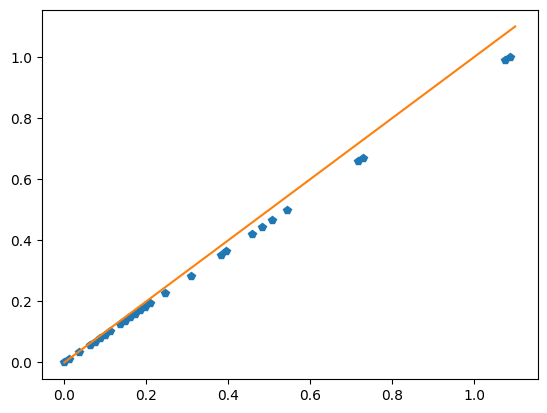

In [159]:
plt.plot(raw_feats[:,0], raw_feats[:, 1], 'p')
plt.plot([0, 1.1], [0, 1.1])

In [160]:
scaler = StandardScaler(with_mean=True, with_std=False)
pca = PCA()

emb_temp = scaler.fit_transform(emb_feats)
emb_pca = pca.fit_transform(emb_temp)

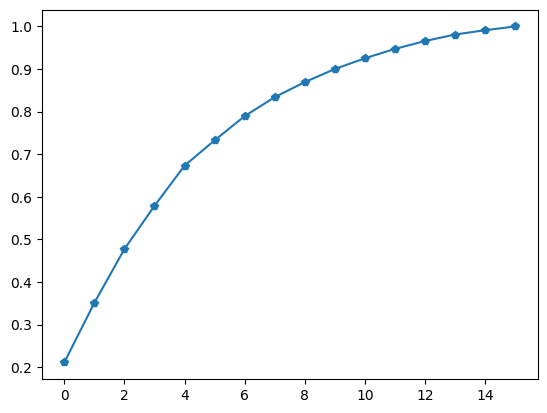

In [161]:
plt.plot(np.cumsum(pca.explained_variance_ratio_), 'p-')

Text(0.5, 1.0, 'First two PCA components')

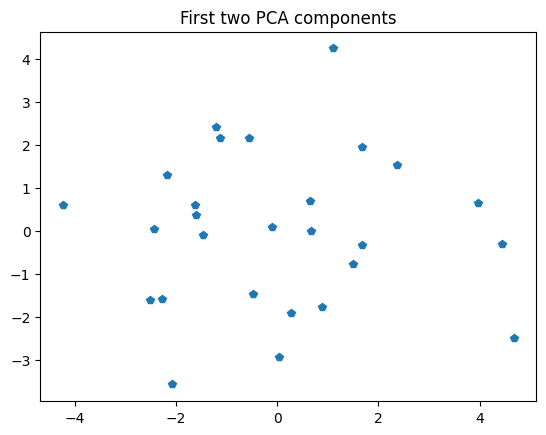

In [162]:
plt.plot(emb_pca[:,0], emb_pca[:, 1], 'p')
plt.title("First two PCA components")

AttributeError: 'numpy.ndarray' object has no attribute 'numpy'

/home/sanjay/.conda/envs/pyg/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/sanjay/.conda/envs/pyg/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/sanjay/.conda/envs/pyg/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/sanjay/.conda/envs/pyg/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/sanjay/.conda/envs/pyg/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/

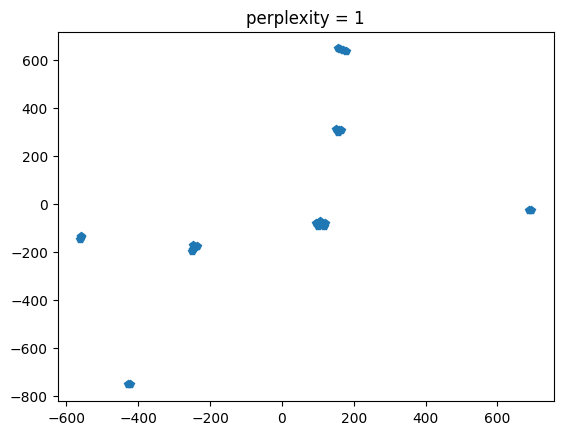

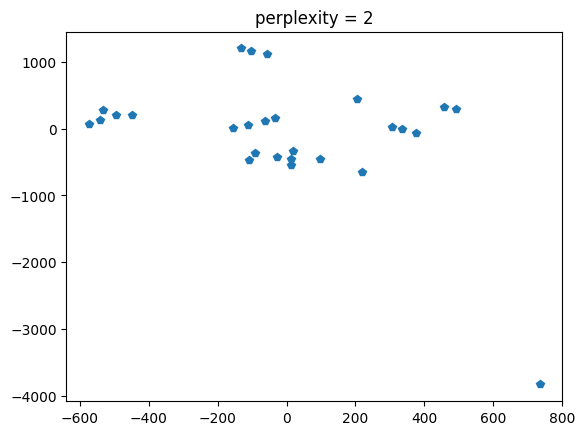

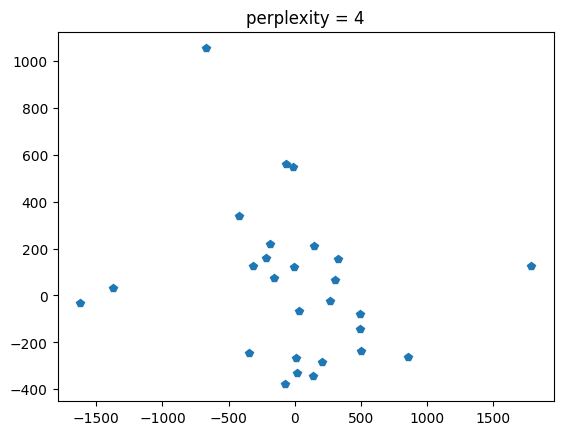

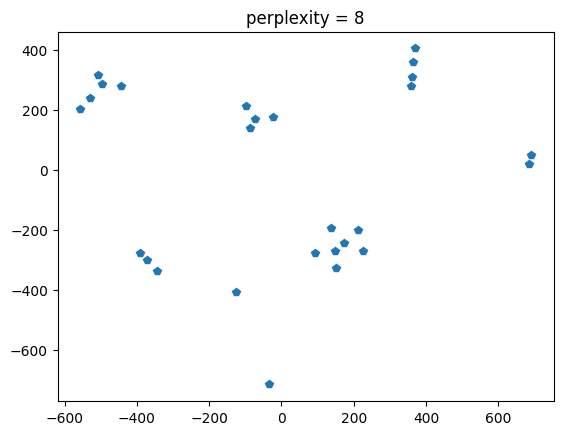

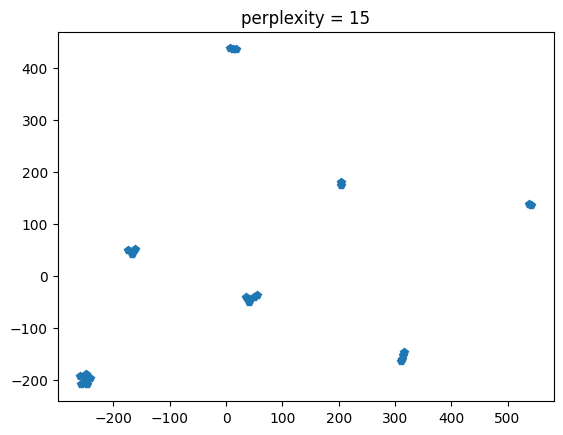

In [174]:
from sklearn.cluster import KMeans

cl_res = {}
for perp in [1, 2, 4, 8, 15]:
    tsne = TSNE(n_components=2, perplexity=1)
    emb_tsne = tsne.fit_transform(emb_feats)

    cl = KMeans(n_clusters=7)
    cl_res[perp] = cl.fit_predict(emb_tsne)
    
    plt.figure()
    plt.plot(emb_tsne[:,0], emb_tsne[:, 1], 'p')
    plt.title(f'perplexity = {perp}')

In [183]:
np.where(cl_res[15]==0)[0]

array([ 9, 11, 12, 26])

In [192]:
[node_to_idx[tuple(r)] for r in raw_feats[np.where(cl_res[15]==0)[0]]]

[9, 11, 12, 26]

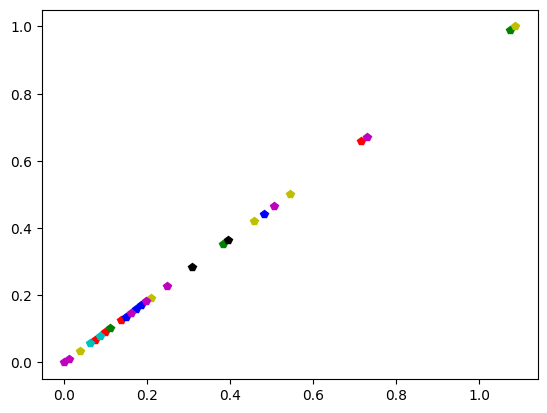

In [197]:
ncl = 7

colors = {0: 'r',
          1: 'b',
          2: 'g',
          3: 'y',
          4: 'k',
          5: 'm',
          6: 'c'
         }

plt.figure()
for n in range(ncl):
    row_ids = np.where(cl_res[15]==n)[0]
    row_feats = raw_feats[row_ids]
    
    plt.plot(row_feats[:,0], row_feats[:,1], 'p', color = colors[n])

##### TODO:

- add embeddings (done)
- add batching
- add sampling of neighborhoods
- add attention